In [1]:
%load_ext autoreload
%autoreload 2
from dimension_reduction import *

# Similarity Function Explore

In [2]:
# takes about 4-5m to run this
root_folder = 'data/MET'
images_array = load_images_from_folders(root_folder)
images_array_grey = load_images_from_folders(root_folder, mode='L')
flattened_grey = np.array([image.flatten() for image in images_array_grey])
flattened_color = np.array([image.flatten() for image in images_array])

In [9]:
data = flattened_grey[:500]

# step 1: Sstandarlize data set
scaler = StandardScaler()
X = scaler.fit(data).transform(data)

# step 2: Create adjancency matrix and make it symmetric
adj_directed = kneighbors_graph(X, 3, mode='connectivity', include_self=True).toarray()
W = np.maximum(adj_directed, adj_directed.T)

# step 3: Calculate Diagnal and Laplacian Matrix
W_sum = np.sum(W, axis=1)
D = np.diag(W_sum.T) # need to be array
L = D - W

L # may need to clip?

array([[3., 0., 0., ..., 0., 0., 0.],
       [0., 9., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 4., 0., 0.],
       [0., 0., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 0., 0., 2.]])

# Gaussian Radial Kernel Function

In [19]:
def gaussian_rbf_kernel(X, sigma=1.0):
    """
    Compute the Gaussian RBF (Radial Basis Function) kernel matrix for a dataset.

    Parameters:
    - X: A numpy array of shape (n_samples, n_features) representing the dataset.
    - sigma: The bandwidth of the RBF kernel. A higher sigma means a smoother kernel.

    Returns:
    - K: A numpy array of shape (n_samples, n_samples) where K[i, j] represents the
      similarity between the ith and jth samples in X.
    """
    # Compute the squared Euclidean distance matrix
    sq_dists = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(X**2, axis=1) - 2 * np.dot(X, X.T)
    
    # Cap the distances to avoid overflow in exp
    sq_dists = np.clip(sq_dists, a_min=None, a_max=700)  # Cap values to avoid overflow

    # Compute the Gaussian RBF kernel matrix
    K = np.exp(-sq_dists / (2 * sigma**2))
    
    return K

In [20]:
gaussian_rbf_kernel(data)

/var/folders/yt/5gdjwln55x9_stgx851x0yb80000gn/T/ipykernel_61001/2277928796.py:20: RuntimeWarning: overflow encountered in exp
  K = np.exp(-sq_dists / (2 * sigma**2))


array([[inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

# SSIM Index Matrix

In [27]:
def ssim_index(img1, img2, C1=6.5025, C2=58.5225):
    # Convert images to float64 for precision in calculations
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    
    # Mean of the images
    mean_img1 = np.mean(img1)
    mean_img2 = np.mean(img2)
    
    # Variance and covariance
    var_img1 = np.var(img1)
    var_img2 = np.var(img2)
    cov_img1_img2 = np.cov(img1.ravel(), img2.ravel())[0, 1]
    
    # Calculate SSIM components
    luminance = (2 * mean_img1 * mean_img2 + C1) / (mean_img1**2 + mean_img2**2 + C1)
    contrast = (2 * np.sqrt(var_img1 * var_img2) + C2) / (var_img1 + var_img2 + C2)
    structure = (cov_img1_img2 + C2/2) / (np.sqrt(var_img1) * np.sqrt(var_img2) + C2/2)
    
    # Overall SSIM index
    return luminance * contrast * structure

In [29]:
def compute_ssim_matrix(images):
    n = len(images)
    ssim_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):  # Compute only for i <= j to avoid redundant calculations
            if i == j:
                ssim_matrix[i, j] = 1.0  # The similarity of an image with itself is 1
            else:
                ssim_value = ssim_index(images[i], images[j])
                ssim_matrix[i, j] = ssim_value
                ssim_matrix[j, i] = ssim_value  # SSIM is symmetric, fill both [i, j] and [j, i]
    
    return ssim_matrix

In [34]:
W = compute_ssim_matrix(data)
W

array([[ 1.        ,  0.06808441, -0.29754935, ..., -0.13154588,
        -0.01522379,  0.04210354],
       [ 0.06808441,  1.        ,  0.31823662, ...,  0.36906564,
        -0.08314411,  0.19442554],
       [-0.29754935,  0.31823662,  1.        , ...,  0.4088348 ,
        -0.02407583,  0.17954433],
       ...,
       [-0.13154588,  0.36906564,  0.4088348 , ...,  1.        ,
        -0.08771707,  0.34322861],
       [-0.01522379, -0.08314411, -0.02407583, ..., -0.08771707,
         1.        , -0.02848784],
       [ 0.04210354,  0.19442554,  0.17954433, ...,  0.34322861,
        -0.02848784,  1.        ]])

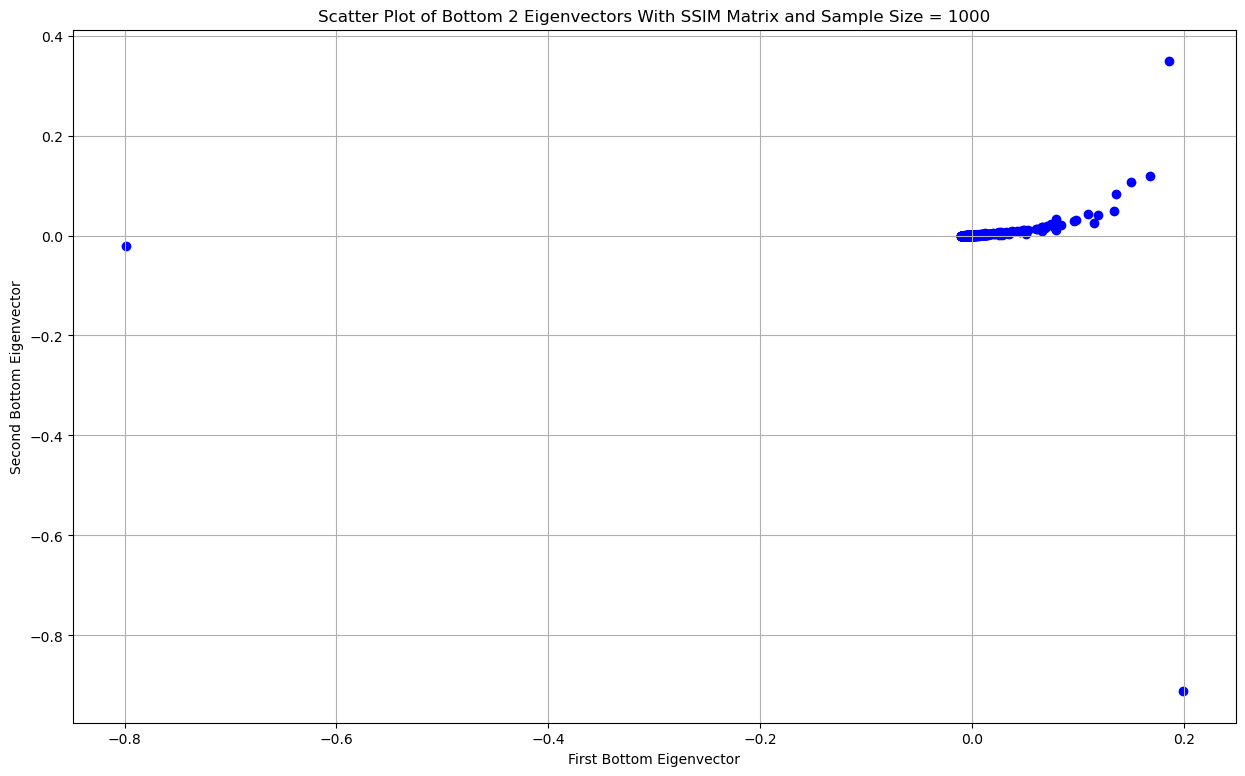

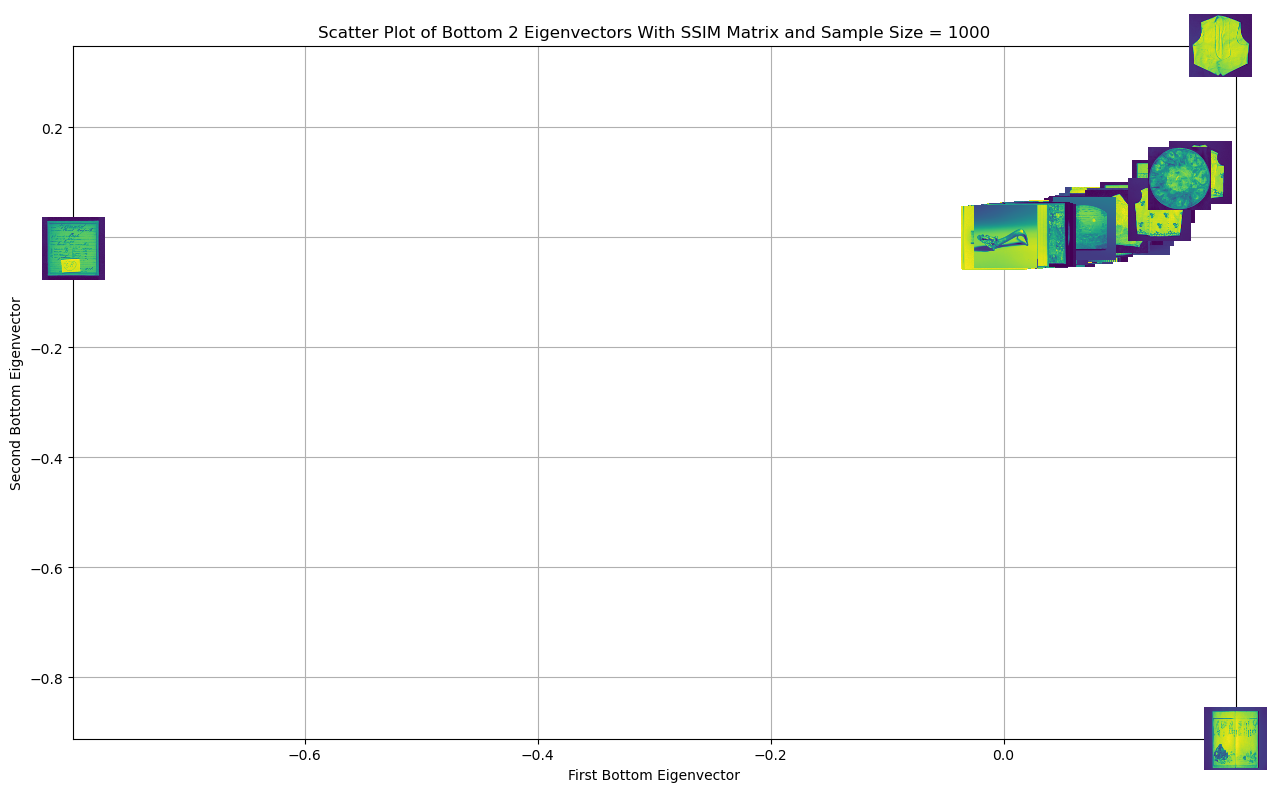

In [36]:
laplacian_eigenmap(data=flattened_grey[:1000], image_dim=128)